# Profitable Strategy with Markov Chain

In the excel sheet, I've proven that the change in price in each days are not random. So using this information, we made a simple strategy based on single transition and buying selling on opening and closing. Now let's try it for multiple transition and test it as well. 

In [1]:
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import datetime
from random import randint
import seaborn as sns
import scipy.stats as stats
import warnings
warnings.filterwarnings('ignore')

In [2]:
data_raw = pd.read_csv('AMD.csv')
data_raw['Date'] = pd.to_datetime(data_raw['Date'])
data_raw 

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-03-18,0.000000,3.125000,2.937500,3.031250,3.031250,727200
1,1980-03-19,0.000000,3.083333,3.020833,3.041667,3.041667,295200
2,1980-03-20,0.000000,3.062500,3.010417,3.010417,3.010417,159600
3,1980-03-21,0.000000,3.020833,2.906250,2.916667,2.916667,130800
4,1980-03-24,0.000000,2.916667,2.635417,2.666667,2.666667,436800
...,...,...,...,...,...,...,...
11026,2023-12-11,130.559998,135.039993,128.250000,134.410004,134.410004,98668300
11027,2023-12-12,132.250000,139.889999,131.899994,137.610001,137.610001,111677800
11028,2023-12-13,137.970001,139.240005,136.029999,138.190002,138.190002,70651600
11029,2023-12-14,138.889999,141.820007,135.729996,138.000000,138.000000,76115200


Split training and test data set. Set the test as the recent 3 years, and train our strategy on all data before that.  

In [3]:
data_test = data_raw [data_raw["Date"]>'2020-12-14']
data = data_raw [data_raw["Date"]<'2020-12-15']

# Feature Engineering

Separate out the dates

In [4]:
data["Date"] = pd.to_datetime(data["Date"],dayfirst= True)
data['DayOfWeek'] = data['Date'].dt.weekday
data["Quarter"]=data["Date"].dt.quarter
data['Week'] = data['Date'].dt.isocalendar().week
data['Month'] = data['Date'].dt.month
data["Year"] = data["Date"].dt.year
#data.drop("Date", axis = 1, inplace = True)
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek,Quarter,Week,Month,Year
0,1980-03-18,0.0,3.125000,2.937500,3.031250,3.031250,727200,1,1,12,3,1980
1,1980-03-19,0.0,3.083333,3.020833,3.041667,3.041667,295200,2,1,12,3,1980
2,1980-03-20,0.0,3.062500,3.010417,3.010417,3.010417,159600,3,1,12,3,1980
3,1980-03-21,0.0,3.020833,2.906250,2.916667,2.916667,130800,4,1,12,3,1980
4,1980-03-24,0.0,2.916667,2.635417,2.666667,2.666667,436800,0,1,13,3,1980


Get Percentage daily change of price

In [5]:
data["DailyChange"] = (data["Close"]- data["Open"])/data["Open"]
data

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek,Quarter,Week,Month,Year,DailyChange
0,1980-03-18,0.000000,3.125000,2.937500,3.031250,3.031250,727200,1,1,12,3,1980,inf
1,1980-03-19,0.000000,3.083333,3.020833,3.041667,3.041667,295200,2,1,12,3,1980,inf
2,1980-03-20,0.000000,3.062500,3.010417,3.010417,3.010417,159600,3,1,12,3,1980,inf
3,1980-03-21,0.000000,3.020833,2.906250,2.916667,2.916667,130800,4,1,12,3,1980,inf
4,1980-03-24,0.000000,2.916667,2.635417,2.666667,2.666667,436800,0,1,13,3,1980,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10270,2020-12-08,94.050003,94.739998,91.900002,92.919998,92.919998,33907500,1,4,50,12,2020,-0.012015
10271,2020-12-09,92.760002,94.699997,89.160004,89.830002,89.830002,52170400,2,4,50,12,2020,-0.031587
10272,2020-12-10,89.550003,92.089996,89.029999,91.660004,91.660004,33804400,3,4,50,12,2020,0.023562
10273,2020-12-11,91.540001,92.330002,90.160004,91.650002,91.650002,28368100,4,4,50,12,2020,0.001202


Remove invalid values and infinite daily returns due to error of opening being 0.

In [6]:
data = data.dropna()
data = data[data["Open"]!=0]
data = data[1:]
data

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek,Quarter,Week,Month,Year,DailyChange
760,1983-03-21,8.968750,9.031250,8.812500,9.000000,9.000000,510800,0,1,12,3,1983,0.003484
761,1983-03-22,8.718750,8.968750,8.500000,8.500000,8.500000,328000,1,1,12,3,1983,-0.025090
762,1983-03-23,8.500000,8.812500,8.468750,8.718750,8.718750,427200,2,1,12,3,1983,0.025735
763,1983-03-24,8.718750,8.781250,8.656250,8.781250,8.781250,393200,3,1,12,3,1983,0.007168
764,1983-03-25,8.906250,9.062500,8.750000,8.875000,8.875000,210400,4,1,12,3,1983,-0.003509
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10270,2020-12-08,94.050003,94.739998,91.900002,92.919998,92.919998,33907500,1,4,50,12,2020,-0.012015
10271,2020-12-09,92.760002,94.699997,89.160004,89.830002,89.830002,52170400,2,4,50,12,2020,-0.031587
10272,2020-12-10,89.550003,92.089996,89.029999,91.660004,91.660004,33804400,3,4,50,12,2020,0.023562
10273,2020-12-11,91.540001,92.330002,90.160004,91.650002,91.650002,28368100,4,4,50,12,2020,0.001202


Let's add labels to each of the levels of daily change.

In [7]:
labels = ["E","D","C","B","A"]
data["1dayLabel"] = pd.qcut(data["DailyChange"], 5, labels=labels)
data #A indicates a high return and E is a high loss or low return. 

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek,Quarter,Week,Month,Year,DailyChange,1dayLabel
760,1983-03-21,8.968750,9.031250,8.812500,9.000000,9.000000,510800,0,1,12,3,1983,0.003484,C
761,1983-03-22,8.718750,8.968750,8.500000,8.500000,8.500000,328000,1,1,12,3,1983,-0.025090,E
762,1983-03-23,8.500000,8.812500,8.468750,8.718750,8.718750,427200,2,1,12,3,1983,0.025735,A
763,1983-03-24,8.718750,8.781250,8.656250,8.781250,8.781250,393200,3,1,12,3,1983,0.007168,B
764,1983-03-25,8.906250,9.062500,8.750000,8.875000,8.875000,210400,4,1,12,3,1983,-0.003509,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10270,2020-12-08,94.050003,94.739998,91.900002,92.919998,92.919998,33907500,1,4,50,12,2020,-0.012015,D
10271,2020-12-09,92.760002,94.699997,89.160004,89.830002,89.830002,52170400,2,4,50,12,2020,-0.031587,E
10272,2020-12-10,89.550003,92.089996,89.029999,91.660004,91.660004,33804400,3,4,50,12,2020,0.023562,A
10273,2020-12-11,91.540001,92.330002,90.160004,91.650002,91.650002,28368100,4,4,50,12,2020,0.001202,C


Below are ranges and the details of each labels. In summary, A is a high return, C is a no return, E is a high loss situation.

In [8]:
data[data["1dayLabel"]=="A"]["DailyChange"].describe()

count    1903.000000
mean        0.043905
std         0.025670
min         0.020906
25%         0.027093
50%         0.035821
75%         0.052348
max         0.273885
Name: DailyChange, dtype: float64

In [9]:
data[data["1dayLabel"]=="B"]["DailyChange"].describe()

count    1903.000000
mean        0.012142
std         0.004573
min         0.004464
25%         0.008000
50%         0.012048
75%         0.015748
max         0.020896
Name: DailyChange, dtype: float64

In [10]:
data[data["1dayLabel"]=="C"]["DailyChange"].describe()

count    1901.000000
mean       -0.001611
std         0.003410
min        -0.007937
25%        -0.004545
50%         0.000000
75%         0.000000
max         0.004459
Name: DailyChange, dtype: float64

In [11]:
data[data["1dayLabel"]=="D"]["DailyChange"].describe()

count    1905.000000
mean       -0.014749
std         0.004112
min        -0.022571
25%        -0.018085
50%        -0.014286
75%        -0.011416
max        -0.007937
Name: DailyChange, dtype: float64

In [12]:
data[data["1dayLabel"]=="E"]["DailyChange"].describe()

count    1903.000000
mean       -0.041666
std         0.020431
min        -0.281250
25%        -0.048258
50%        -0.035573
75%        -0.028302
max        -0.022581
Name: DailyChange, dtype: float64

In [13]:

data["1dayLabel"] = data["1dayLabel"].astype("str")
data["2dayLabel"] = data["1dayLabel"] + data["1dayLabel"].shift(1)
for i in range(2,10):
    col_name = str(i+1) + "dayLabel"
    prev_col_name = str(i) + "dayLabel"
    data[col_name] =  data[prev_col_name] + data["1dayLabel"].shift(i)
data["Next_day"] = data["1dayLabel"].shift(-1)

data

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek,Quarter,Week,...,2dayLabel,3dayLabel,4dayLabel,5dayLabel,6dayLabel,7dayLabel,8dayLabel,9dayLabel,10dayLabel,Next_day
760,1983-03-21,8.968750,9.031250,8.812500,9.000000,9.000000,510800,0,1,12,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,E
761,1983-03-22,8.718750,8.968750,8.500000,8.500000,8.500000,328000,1,1,12,...,EC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,A
762,1983-03-23,8.500000,8.812500,8.468750,8.718750,8.718750,427200,2,1,12,...,AE,AEC,NaN,NaN,NaN,NaN,NaN,NaN,NaN,B
763,1983-03-24,8.718750,8.781250,8.656250,8.781250,8.781250,393200,3,1,12,...,BA,BAE,BAEC,NaN,NaN,NaN,NaN,NaN,NaN,C
764,1983-03-25,8.906250,9.062500,8.750000,8.875000,8.875000,210400,4,1,12,...,CB,CBA,CBAE,CBAEC,NaN,NaN,NaN,NaN,NaN,D
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10270,2020-12-08,94.050003,94.739998,91.900002,92.919998,92.919998,33907500,1,4,50,...,DD,DDB,DDBD,DDBDB,DDBDBC,DDBDBCA,DDBDBCAD,DDBDBCADB,DDBDBCADBC,E
10271,2020-12-09,92.760002,94.699997,89.160004,89.830002,89.830002,52170400,2,4,50,...,ED,EDD,EDDB,EDDBD,EDDBDB,EDDBDBC,EDDBDBCA,EDDBDBCAD,EDDBDBCADB,A
10272,2020-12-10,89.550003,92.089996,89.029999,91.660004,91.660004,33804400,3,4,50,...,AE,AED,AEDD,AEDDB,AEDDBD,AEDDBDB,AEDDBDBC,AEDDBDBCA,AEDDBDBCAD,C
10273,2020-12-11,91.540001,92.330002,90.160004,91.650002,91.650002,28368100,4,4,50,...,CA,CAE,CAED,CAEDD,CAEDDB,CAEDDBD,CAEDDBDB,CAEDDBDBC,CAEDDBDBCA,A


Now let's analyse the 2 day sequence of returns

In [14]:
two_day_outcome = data.groupby(["2dayLabel","Next_day"])["Next_day"].count()
two_day_outcome

2dayLabel  Next_day
AA         A           103
           B            71
           C            64
           D            89
           E            97
                      ... 
EE         A           120
           B            70
           C            64
           D            71
           E           124
Name: Next_day, Length: 125, dtype: int64

In [15]:
result = pd.DataFrame(columns = ["Label","outcome_no"])

for i in range(len(two_day_outcome)):
    if two_day_outcome.keys()[i][1] == "A" or two_day_outcome.keys()[i][1] == "B":
        result.loc[len(result)] = [two_day_outcome.keys()[i],two_day_outcome[i]]
result.sort_values("outcome_no", ascending = False).head()

,Label,outcome_no
48,"(EE, A)",120
0,"(AA, A)",103
40,"(EA, A)",103
27,"(CD, B)",97
8,"(AE, A)",95


A high gains day is most likely to occur after 2 heavily lost days. For simplicity, we will use top 3 scenarios that result in a high day in our strategy. So we'll only buy and sell on days after EE or AA or EA has occurred.

## Testing the 2 day sequence

Add the same features in the testing set

In [16]:
data_test["Date"] = pd.to_datetime(data_test["Date"],dayfirst= True)
data_test['DayOfWeek'] = data_test['Date'].dt.weekday
data_test["Quarter"]=data_test["Date"].dt.quarter
data_test['Week'] = data_test['Date'].dt.isocalendar().week
data_test['Month'] = data_test['Date'].dt.month
data_test["Year"] = data_test["Date"].dt.year
#data_test.drop("Date", axis = 1, inplace = True)
data_test["DailyChange"] = (data_test["Adj Close"]- data_test["Open"])/data_test["Open"]

In [17]:
# applies the A,B,C,D,E range we had in our training set to the testing set. 
def return_classify(data,a_min,b_min,c_min,d_min):
    
    if data["DailyChange"] >= a_min:
        return "A"
    elif data["DailyChange"] >= b_min:
        return "B"
    elif data["DailyChange"] >= c_min:
        return "C"
    elif data["DailyChange"] >= d_min:
        return "D"
    else:
        return "E"

In [18]:
a_min = data[data["1dayLabel"]=="A"]["DailyChange"].min()
b_min = data[data["1dayLabel"]=="B"]["DailyChange"].min()
c_min = data[data["1dayLabel"]=="C"]["DailyChange"].min()
d_min = data[data["1dayLabel"]=="D"]["DailyChange"].min()

data_test["1dayLabel"] = data_test.apply(return_classify,args = (a_min,b_min,c_min,d_min),axis = 1)
data_test["2dayLabel"] = data_test["1dayLabel"] + data_test["1dayLabel"].shift(1)
for i in range(2,5):
    col_name = str(i+1) + "dayLabel"
    prev_col_name = str(i) + "dayLabel"
    data_test[col_name] =  data_test[prev_col_name] + data_test["1dayLabel"].shift(i)
data_test["Next_day"] = data_test["1dayLabel"].shift(-1)
data_test

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek,Quarter,Week,Month,Year,DailyChange,1dayLabel,2dayLabel,3dayLabel,4dayLabel,5dayLabel,Next_day
10275,2020-12-15,95.930000,97.980003,95.449997,97.120003,97.120003,57232700,1,4,51,12,2020,0.012405,B,NaN,NaN,NaN,NaN,C
10276,2020-12-16,97.040001,97.269997,95.459999,96.849998,96.849998,34909000,2,4,51,12,2020,-0.001958,C,CB,NaN,NaN,NaN,C
10277,2020-12-17,97.550003,97.919998,96.250000,96.839996,96.839996,32023700,3,4,51,12,2020,-0.007278,C,CC,CCB,NaN,NaN,D
10278,2020-12-18,97.269997,97.680000,93.559998,95.919998,95.919998,51823100,4,4,51,12,2020,-0.013879,D,DC,DCC,DCCB,NaN,D
10279,2020-12-21,94.250000,95.279999,91.080002,93.230003,93.230003,47093900,0,4,52,12,2020,-0.010822,D,DD,DDC,DDCC,DDCCB,C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11026,2023-12-11,130.559998,135.039993,128.250000,134.410004,134.410004,98668300,0,4,50,12,2023,0.029488,A,AC,ACA,ACAE,ACAEB,A
11027,2023-12-12,132.250000,139.889999,131.899994,137.610001,137.610001,111677800,1,4,50,12,2023,0.040529,A,AA,AAC,AACA,AACAE,C
11028,2023-12-13,137.970001,139.240005,136.029999,138.190002,138.190002,70651600,2,4,50,12,2023,0.001595,C,CA,CAA,CAAC,CAACA,C
11029,2023-12-14,138.889999,141.820007,135.729996,138.000000,138.000000,76115200,3,4,50,12,2023,-0.006408,C,CC,CCA,CCAA,CCAAC,C


Now let's test out our strategy and see how much they make on average per year.

In [19]:
strategy = data_test[(data_test.shift(-1)["2dayLabel"]== "EE") | 
                     (data_test.shift(-1)["2dayLabel"]== "AA") | 
                     (data_test.shift(-1)["2dayLabel"]== "EA")]
strategy

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek,Quarter,Week,Month,Year,DailyChange,1dayLabel,2dayLabel,3dayLabel,4dayLabel,5dayLabel,Next_day
10292,2021-01-11,94.029999,99.230003,93.760002,97.250000,97.250000,48600200,0,1,2,1,2021,0.034244,A,AD,ADA,ADAD,ADADB,E
10303,2021-01-27,91.099998,91.879997,86.220001,88.839996,88.839996,73341200,2,1,4,1,2021,-0.024808,E,EC,ECC,ECCD,ECCDA,E
10322,2021-02-24,84.330002,87.089996,82.809998,86.940002,86.940002,40821200,2,1,8,2,2021,0.030950,A,AB,ABE,ABEC,ABECC,E
10326,2021-03-02,86.919998,86.949997,84.040001,84.129997,84.129997,34828200,1,1,9,3,2021,-0.032098,E,EB,EBB,EBBE,EBBEA,E
10327,2021-03-03,84.279999,84.379997,80.849998,80.860001,80.860001,43541000,2,1,9,3,2021,-0.040579,E,EE,EEB,EEBB,EEBBE,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10945,2023-08-16,110.089996,110.440002,106.980003,107.190002,107.190002,54327300,2,3,33,8,2023,-0.026342,E,EC,ECA,ECAD,ECADD,E
10950,2023-08-23,105.650002,110.080002,105.000000,109.430000,109.430000,54656300,2,3,34,8,2023,0.035778,A,AE,AEB,AEBA,AEBAE,E
10994,2023-10-25,100.419998,101.029999,95.230003,96.059998,96.059998,53424500,2,4,43,10,2023,-0.043418,E,EB,EBC,EBCC,EBCCD,E
10998,2023-10-31,96.239998,98.820000,94.070000,98.500000,98.500000,79547100,1,4,44,10,2023,0.023483,A,AC,ACB,ACBE,ACBEE,A


In [98]:
market_return = round(((1 + data_test["DailyChange"]).prod()**(1/3)-1)*100,2)
default_average_return = round(np.mean(data_test["DailyChange"])**100,2)
strategy_return = round(((1 + strategy["DailyChange"]).prod()**(1/3)-1)*100,2)
strategy_average_return = round(np.mean(strategy["DailyChange"])*100,2)

print(f"Simple buy and sell everyday yearly: {market_return}%")
print(f"Default Daily Average Return: {default_average_return}%")
print(f"Strategy yearly return: {strategy_return}%")
print(f"Strategy Daily Average Return: {strategy_average_return}%")

Simple buy and sell everyday yearly: 1.83%
Default Daily Average Return: 0.0%
Strategy yearly return: 75.26%
Strategy Daily Average Return: 2.02%


Compared to our default method of just buying and selling at opening and closing everyday, average annual return of 75% per year is an amazing return for a simple strategy like this. Now let's see if we can find even better strategy with more transition in mind. 

In [21]:
def strategy_compare(data,data_test):
    final_result = pd.DataFrame(columns = ["transition_no","yearly_return","risk","count"])
    final_result.loc[len(final_result)] = ["Default",(1 + data_test["DailyChange"]).prod()**(1/3)-1,np.std(data_test["DailyChange"]),len(data_test)]
    for i in range(5):
        col_name = str(i+1)+"dayLabel"
            
        outcome = data.groupby([col_name,"Next_day"])["Next_day"].count()
        result = pd.DataFrame(columns = ["Label","outcome_no"])
        
        #get everything that has outcomes A or B
        for i in range(len(outcome)):
            if outcome.keys()[i][1] == "A" or outcome.keys()[i][1] == "B":
                result.loc[len(result)] = [outcome.keys()[i],outcome[i]]
        result = result.sort_values("outcome_no", ascending = False)
        
        #get the top three strategies and put the result into the final_result table
        labels = [result["Label"][0][0],result["Label"][1][0],result["Label"][2][0]]
        strategy = data_test[data_test.shift(-1)[col_name].isin(labels)]
        final_result.loc[len(final_result)] = [col_name,(1 + strategy["DailyChange"]).prod()**(1/3)-1,np.std(strategy["DailyChange"]),len(strategy)]
        
    return final_result
    

In [22]:
strategy_compare(data,data_test)

,transition_no,yearly_return,risk,count
0,Default,0.018309,0.027557,756
1,1dayLabel,-0.074142,0.029533,314
2,2dayLabel,0.797650,0.021899,63
3,3dayLabel,0.252802,0.018792,17
4,4dayLabel,0.077245,0.007943,7
5,5dayLabel,0.029309,0.008227,3


The strategy of looking back two days seem to work extremely well and adding more days just decreases the returns but it's still bigger than the default method. The return here is extremely big so there is no denying we need to take this with a big grain of salt. Let us analyse our test data to see if the testing was the issue. 

In [33]:
data_test["DailyChange"].describe()

count    756.000000
mean       0.000451
std        0.027575
min       -0.102743
25%       -0.014732
50%       -0.000389
75%        0.016089
max        0.115245
Name: DailyChange, dtype: float64

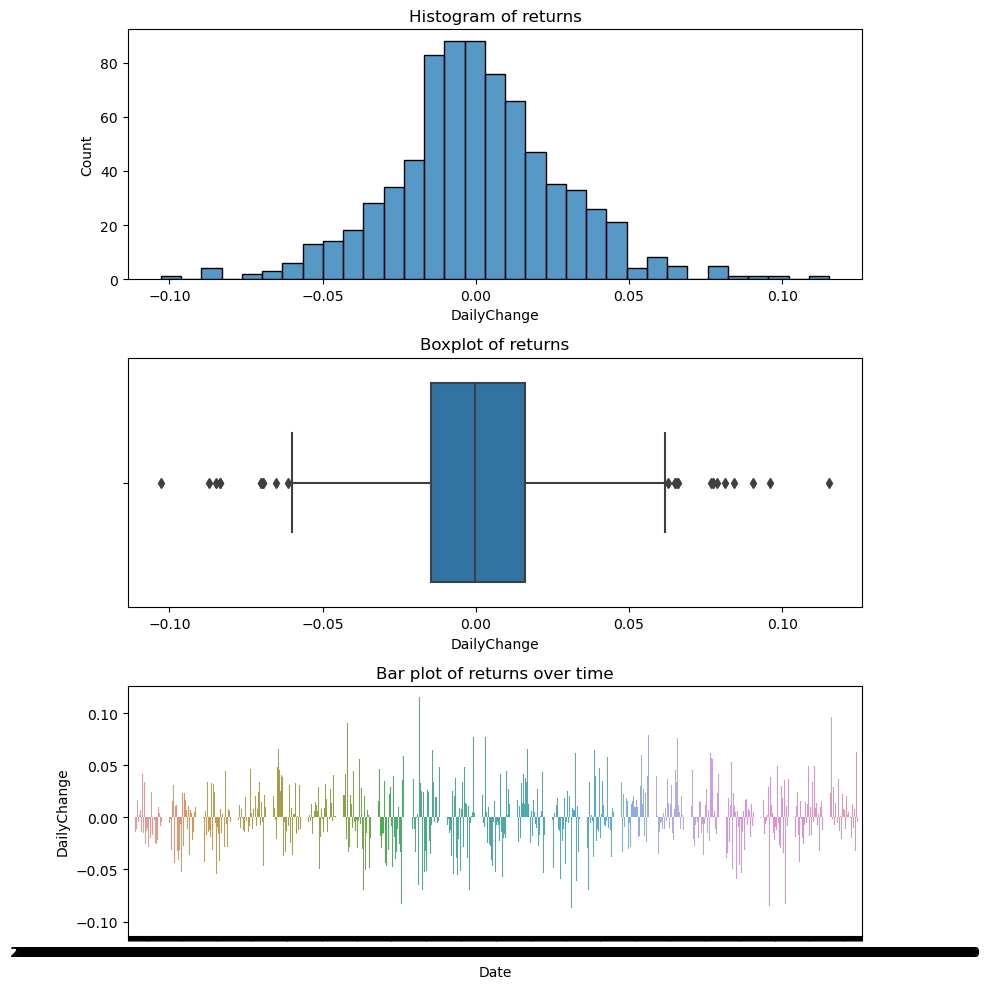

In [84]:
fig,ax = plt.subplots(3,1, figsize = (10,10))
sns.histplot(data_test["DailyChange"],ax=ax[0])
ax[0].set_title("Histogram of returns")
sns.boxplot(x= data_test["DailyChange"], ax = ax[1])
ax[1].set_title("Boxplot of returns")
sns.barplot(x=data_test["Date"],y=data_test["DailyChange"],ax = ax[2])
ax[2].set_title("Bar plot of returns over time")
plt.tight_layout()
plt.show()

The daily returns seem very normally distributed with a mean very close to 0. This indicates that the 3 years we used for testing is not a period that only had big returns but had a balanced mix of loss. Let's do a t test with null hypothesis of the mean being 0 to further justify the validity of the test data set. 

In [85]:
t_statistic, p_value = stats.ttest_1samp(data_test["DailyChange"], 0)

print(f'T-statistic: {t_statistic}')
print(f'P-value: {p_value}')

T-statistic: 0.44999101708138073
P-value: 0.6528460882333069


The high p value indicates there is no evidence to deny that the mean is 0. 

# Conclusion

Is this simply an accident that happens so that it only works for this stock? We need to test it in other stocks as well, also we may need to integrate other methods to find a better buy signal if needed. Talking about signals, we have fixed a sell off point in this simple strategy and obviously it's not optimal. For a better solution into profitability, we need to find a good selling point as well. However, if yearly profitability really is close to 80%, would we need to find it? Let's find out in the next episode of Dragonball Z. 